# Bitcoin Sender Address Analysis - Bear Phases between 2015 - 2021
- by Malik Sogukoglu

## References
- Inspiration for Workflow structure: 
 - https://www.bmc.com/blogs/python-spark-k-means-example/
 - https://www.kaggle.com/statsfromarg/btc-data-exploratory-analysis-with-txn
- K-means clustering in Spark
 - https://spark.apache.org/docs/latest/ml-clustering.html
 - https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
- Sampling:
 - https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- Filter pushdown: 
 - https://engineering.dynatrace.com/blog/optimizing-spark-queries-with-filter-pushdown/
 - https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
- Read data: 
 - Reading several files: https://stackoverflow.com/questions/49898742/pandas-reading-csv-files-with-partial-wildcard
 - Correct processing of the date value as part of filtering (1): https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime 
 - Correct processing of the date value as part of filtering(2) :https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
- In-memory data processing:
 - https://phoenixnap.com/kb/hadoop-vs-spark 
- Disable infer schema
 - https://stackoverflow.com/questions/56927329/spark-option-inferschema-vs-header-true/56933052
- PCA: 
 - https://stackoverflow.com/questions/59883306/how-to-drop-a-column-from-a-spark-dataframe-by-index-where-column-names-can-be-d
 - pca plot variance explained https://datascience-enthusiast.com/Python/PCA_Spark_Python_R
- Plots:
 - 3-D Plots: help received from https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex
            


## Set up environment

In [ ]:
!pip install pyspark

In [1]:
from pyspark.sql import SparkSession


In [2]:
import glob

In [4]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [5]:
from pyspark.sql import functions as F

## Define data schema

In [6]:
schema = StructType([ \
    StructField("sender",StringType(),True), \
    StructField("value",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
  ])

## Set configurations
- Amount of **executors is set to 4**, enabling **parallel processing**
- **Executors** are allocated with **8GB RAM**
- **Spark driver** is allocated with **16GB RAM**
- **Filter pushdown** is enabled, to prevent not requested data to be loaded into memory


In [7]:
from pyspark.conf import SparkConf

config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ("spark.executor.instances", "4"), \

    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true"), \
    ("spark.sql.autoBroadcastJoinThreshold", "-1"), \
    ("spark.sql.parquet.binaryAsString", "true") ]) \
#    ("spark.executor.memoryOverhead", "16384") \


## Open Spark session

In [8]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [9]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)


In [10]:
spark

### Check applied configurations

In [11]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.binaryAsString', 'true'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.app.startTime', '1637857847963'),
 ('spark.driver.port', '56052'),
 ('spark.app.id', 'local-1637857851237'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.sql.warehouse.dir',
  'file:/D:/Bitcoin%20analysis%20-%20Copy/Address%20analysis/spark-warehouse'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '-1'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

## Indicate data to be read

In [15]:
import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\bitcoin_addresses\\", "bitcoin*.csv")))
BITCOIN_PATHS

['D:\\Downloads\\bitcoin_addresses\\bitcoin000000000000.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000001.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000002.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000003.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000004.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000005.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000006.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000007.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000008.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000009.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000010.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000011.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000012.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000013.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000014.csv',
 'D:\\Downloads\\bitcoin_addresses\\bitcoin000000000015.csv',
 'D:\\Do

## Load Bitcoin data into Spark
- Select the columns **Sender**, **Value** and **Fee**.
- Filter by timestamp (**timestamp_in_unix_time**).
- Reshuffle +  Sample data with **factor 0.001**
- Discard NAs
- Load data into cache (with persist()) to avoid having to reload data for different analyses

In [16]:
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("sender","value","fee") \
    .filter( \
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2017-12-18', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2018-12-16', '%Y-%m-%d').timetuple())))) |\
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-07-20', '%Y-%m-%d').timetuple())))) \
            
           ) \
    .sample(False,0.001,1234) \
    .na.drop() \
    .persist()
data_customer.printSchema()

root
 |-- sender: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



## Show explanation of data loading plan
Here Spark shows how it will approach the data loading process, defined above

In [17]:
data_customer.explain()

== Physical Plan ==
InMemoryTableScan [sender#0, value#1, fee#3]
   +- InMemoryRelation [sender#0, value#1, fee#3], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Filter AtLeastNNulls(n, sender#0,value#1,fee#3)
            +- *(1) Sample 0.0, 0.001, false, 1234
               +- *(1) Project [sender#0, value#1, fee#3]
                  +- *(1) Filter (((timestamp_in_unix_seconds#2 >= 1513551600) AND (timestamp_in_unix_seconds#2 <= 1544914800)) OR ((timestamp_in_unix_seconds#2 >= 1618264800) AND (timestamp_in_unix_seconds#2 <= 1626732000)))
                     +- FileScan csv [sender#0,value#1,timestamp_in_unix_seconds#2,fee#3] Batched: false, DataFilters: [(((timestamp_in_unix_seconds#2 >= 1513551600) AND (timestamp_in_unix_seconds#2 <= 1544914800)) O..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/bitcoin_addresses/bitcoin000000000000.csv, file:/D:/Download..., PartitionFilters: [], PushedFilters: [Or(And(GreaterThanOrEqual(timestamp_in_unix_sec

## Show two examples of data loaded into Spark.

In [18]:
data_customer.show(2)

+--------------------+--------+-----+
|              sender|   value|  fee|
+--------------------+--------+-----+
|bc1qhp7fgd65ewgrq...|25000000| 9490|
|1FKVRNEWrLwyNNAEY...|  141189|22656|
+--------------------+--------+-----+
only showing top 2 rows



## Add feature: amount of transactions performed per sender ("c") into dataset

In [19]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
sqlContext.registerDataFrameAsTable(data_customer, "table1")
df2 = sqlContext.sql(" \
                     with counted_sender as (SELECT sender, count(*) as c \
                     from table1 group by sender) \
                     select table1.sender, avg(value) as avg_value, avg(fee) as avg_fee, c \
                     from table1 join counted_sender on table1.sender=counted_sender.sender \
                     group by table1.sender, c order by c desc"
                    )

In [20]:
# sender are filtered out
inputCols=['avg_value', 'avg_fee', 'c']


## Perform Vector Assembler to put the features into suitable format for subsequent K-Means clustering and PCA executions.
Note: Senders are filtered out, since these are hash values, i.e., categorical values, that do not contain any structure to be determined by Clustering + PCA

In [21]:
from pyspark.ml.feature import VectorAssembler
df2.columns
assemble=VectorAssembler(inputCols=inputCols, outputCol='features')
assembled_data=assemble.transform(df2)
assembled_data.show(2)

+--------------------+--------------------+------------------+---+--------------------+
|              sender|           avg_value|           avg_fee|  c|            features|
+--------------------+--------------------+------------------+---+--------------------+
|3422VtS7UtCvXYxoX...|2.3221540241284403E8|21944.211009174312|436|[2.32215402412844...|
|1FoWyxwPXuj4C6abq...|1.1734344521390375E7| 23991.44385026738|374|[1.17343445213903...|
+--------------------+--------------------+------------------+---+--------------------+
only showing top 2 rows



## Standardise data (including mean-centring and scaling)

In [22]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------------------+--------------------+------------------+---+--------------------+--------------------+
|              sender|           avg_value|           avg_fee|  c|            features|        standardized|
+--------------------+--------------------+------------------+---+--------------------+--------------------+
|3422VtS7UtCvXYxoX...|2.3221540241284403E8|21944.211009174312|436|[2.32215402412844...|[0.59498509261600...|
|1FoWyxwPXuj4C6abq...|1.1734344521390375E7| 23991.44385026738|374|[1.17343445213903...|[-0.3063445126918...|
+--------------------+--------------------+------------------+---+--------------------+--------------------+
only showing top 2 rows



## Perform PCA
- 3 PCs to be created

In [23]:
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="standardized")
pca.setOutputCol("pca_features")
model = pca.fit(data_scale_output)
data_scale_output = model.transform(data_scale_output)

In [24]:
data_scale_output.show(2)

+--------------------+--------------------+------------------+---+--------------------+--------------------+--------------------+
|              sender|           avg_value|           avg_fee|  c|            features|        standardized|        pca_features|
+--------------------+--------------------+------------------+---+--------------------+--------------------+--------------------+
|3422VtS7UtCvXYxoX...|2.3221540241284403E8|21944.211009174312|436|[2.32215402412844...|[0.59498509261600...|[-23.965208848897...|
|1FoWyxwPXuj4C6abq...|1.1734344521390375E7| 23991.44385026738|374|[1.17343445213903...|[-0.3063445126918...|[-20.002041565676...|
+--------------------+--------------------+------------------+---+--------------------+--------------------+--------------------+
only showing top 2 rows



## Variance explained by the 3 PCs
Order: PC1, PC2, PC3

In [25]:
model.explainedVariance

DenseVector([0.3593, 0.3329, 0.3078])

## Features explaining the PCs

In [27]:
# PCs: each PC represents a "cluster" of sender and its behaviour
import numpy as np
import pandas as pd
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, 4)], index = inputCols)
df_pc

,PC1,PC2,PC3
avg_value,-0.7039,0.0321,0.7096
avg_fee,-0.6859,0.2288,-0.6908
c,-0.1845,-0.9729,-0.1390


## Perform K-Means clusterings while evaluating each of them
- In order to find the ideal clustering, k-means was performed several times by each time selecting a different number of clusters (k) to be formed, and by each time performing a respective evaluation based on silhouette score.

- The process lasted 5h 37min 21s

In [29]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.8892492900506527
Silhouette Score: 0.8133573772879176
Silhouette Score: 0.7918979249178785
Silhouette Score: 0.8621610648324981
Silhouette Score: 0.7914382059981725
Silhouette Score: 0.7918853901672057
Silhouette Score: 0.8320694267390901
Silhouette Score: 0.8377928894276443
Wall time: 5h 37min 21s


## The diagram below shows the silhouette score achieved by the different clusterings, with a different k chosen each time.

Text(0, 0.5, 'silhouette score')

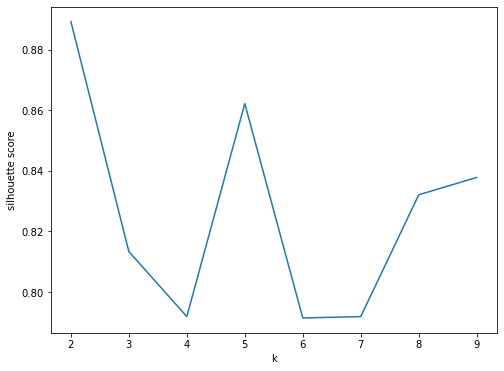

In [30]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

## The optimal number of clusters (K) was chosen to be 4, and on this basis the data points in the dataset were assigned to the clusters.

In [31]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)

## The data in Spark is fetched back into the Python environment using "toPandas" conversion. 
This is done to then crate visualisation on Python environment.

In [34]:
pandasDF=predictions.toPandas()

## A visualisation based on the PCA is created

In [37]:

x = [] # scaled data: feature "avg_value"
y = [] # scaled data: featture "avg_fee"
z = [] # scaled data: feature "count"
for i, j, k in pandasDF["pca_features"].values:
    x.append(i)
    y.append(j)
    z.append(k)

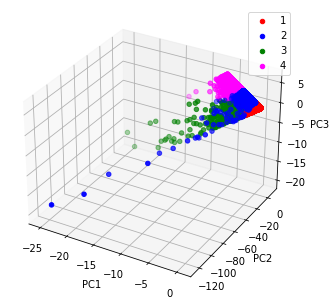

In [39]:
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled data: feature "avg_value"
scatter_y = np.array(y) # scaled data: featture "avg_fee"
scatter_z = np.array(z) # scaled data: feature "count"
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'magenta'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

## Clustering results are visualised in a plot
- Cluster assignments: according to k-means
- Dataset: scaled data from above

In [40]:
x = []
y = []
z = []
for i, j, k in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)
    z.append(k)

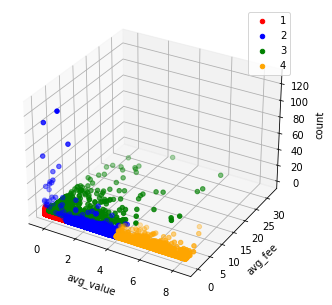

In [46]:


import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled data: feature "avg_value"
scatter_y = np.array(y) # scaled data: feature "avg_fee"
scatter_z = np.array(z) # scaled data: feature "count"
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("avg_value")
plt.ylabel("avg_fee")
ax.set_zlabel("count")
plt.show()
